# Build 

In [ ]:
%%sh
make

# Run Test Cases

In [ ]:
import os
import time
repeats = 60
cores = 32 # change it to the number of the cores
outputDir="measurements/"
def runTest(cmd, testName, languageName, testcases, repeat, heavyThreadtest):
    if heavyThreadtest == testcases: 
        lightOrHeavy = "heavythread"
    else:
        lightOrHeavy = "lightthread"
    for r in range(repeat):
        outputFileName = outputDir+languageName+"."+testName+"."+lightOrHeavy+"."+str(r)+".txt"
        for t in testcases:
            runCmd0 = "echo num: "+str(t) +" >>" + outputFileName
            os.system(runCmd0)
            runCmd = cmd % t + " 2>> " + outputFileName
            bashCmd = 'GREPDB=\"'+runCmd+'\"; /bin/bash -c "$GREPDB"'
            os.system(bashCmd)
            #print(runCmd)
            #time.sleep(1)
def cleanup():
    files = outputDir + "*.txt"
    cmd  = "rm -f " + files
    os.system(cmd)
    files = outputDir + "*.dat"
    cmd  = "rm -f " + files
    os.system(cmd)
    
cleanup()

In [ ]:
heavyThreadTestCases = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
lightThreadTestCases = [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000]

####  Part I  #####

#PQ_Lime
cmd = "time (./bin/mapreduce_lime 1024 %d " +str(cores) +" )"
runTest(cmd, "mapreduce", "Lime",  heavyThreadTestCases, repeats, heavyThreadTestCases)

#PQ_GO
cmd = "time (./bin/mapreduce_go 1024 %d " +str(cores) +" )"
runTest(cmd, "mapreduce", "Go",  heavyThreadTestCases, repeats, heavyThreadTestCases)

#PQ_Erlang
cmd = "time (erl -noshell -pa ./bin/ -s -run mapreduce initial 1024 %d -s init stop)"
runTest(cmd, "mapreduce", "Erlang",  heavyThreadTestCases, repeats, heavyThreadTestCases)

#PQ_Haskell
cmd = "time (./bin/mapreduce_haskell 1024 %d)"
runTest(cmd, "mapreduce", "Haskell",  heavyThreadTestCases, repeats, heavyThreadTestCases)

#PQ_Java
cmd = "time (java -cp bin/ mapreduce 1024 %d)"
runTest(cmd, "mapreduce", "Java",  heavyThreadTestCases, repeats, heavyThreadTestCases)

#PQ_Pthread
cmd = "time (./bin/mapreduce_pthread 1024 %d)"
runTest(cmd, "mapreduce", "Pthread",  heavyThreadTestCases, repeats, heavyThreadTestCases)

#PQ_Rust
cmd = "time (./bin/mapreduce_rust 1024 %d)"
runTest(cmd, "mapreduce", "Rust",  heavyThreadTestCases, repeats, heavyThreadTestCases)

####  Part II  #####

#PQ_Lime
cmd = "time (./bin/mapreduce_lime 1024 %d " +str(cores) +" )"
runTest(cmd, "mapreduce", "Lime",  lightThreadTestCases, repeats, heavyThreadTestCases)

#PQ_GO
cmd = "time (./bin/mapreduce_go 1024 %d " +str(cores) +" )"
runTest(cmd, "mapreduce", "Go",  lightThreadTestCases, repeats, heavyThreadTestCases)

#PQ_Erlang
cmd = "time (erl -noshell -pa bin -s -run mapreduce initial 1024 %d -s init stop)"
runTest(cmd, "mapreduce", "Erlang",  lightThreadTestCases, repeats, heavyThreadTestCases)

#PQ_Haskell
cmd = "time (./bin/mapreduce_haskell 1024 %d)"
runTest(cmd, "mapreduce", "Haskell",  lightThreadTestCases, repeats, heavyThreadTestCases)

#PQ_Rust
#cmd = "time (./bin/mapreduce_rust %d)"
#runTest(cmd, "mapreduce", "Rust",  lightThreadTestCases, repeats, heavyThreadTestCases)

In [1]:
import sys
import re
import glob
import resource

allLanguages = [ "Pthread", "Haskell", "Go", "Erlang", "Java", "Lime", "Rust"]

outputDir="measurements/"
datap = re.compile('num:\\s+([0-9]+).*') #group 1
realp = re.compile('real\\s+([0-9]+)m([0-9]+\\.[0-9]+)s.*') #group 1 and group 2
userp = re.compile('user\\s+([0-9]+)m([0-9]+\\.[0-9]+)s.*')
sysp = re.compile('sys\\s+([0-9]+)m([0-9]+\\.[0-9]+)s.*')

def parse():
    for l in allLanguages:
        results = glob.glob("measurements/*.txt")
        #print(results)
        for f in results:
            ifp=open(f)
            ofp=open(f+'.dat', 'w+')
            line=ifp.readlines()
            row=[None, None]
            for x in line:
                if row[0] is None:
                    m = datap.match(x)
                    if m is not None:
                        row[0] = m.group(1)
                elif row[1] is None:
                    t = realp.match(x)
                    if t is not None:
                        row[1] = str((int(t.group(1))*60+float(t.group(2)))*1000)
                        #print(row[1])
                        ofp.write(row[0])
                        ofp.write(' ')
                        ofp.write(row[1])
                        ofp.write(' ')
                        ofp.write('\n')
                        row = [None, None]
            ofp.close()

parse()

In [2]:
%%file gendata.sh
./../gnuplotme --set x file $1.1.txt.dat 1 --set z avg 2 1 95 $1.*.txt.dat --plot x xaxis --plot z 95CI --outfile $1

Overwriting gendata.sh


In [3]:
%%sh
chmod +x ../gnuplotme

In [4]:
import os
testcases = ["mapreduce"] 
lightLanguages = [ "Haskell", "Go", "Erlang", "Lime"]
#lightLanguages = ["Lime"]
outputDir="measurements/"

for l in allLanguages:
    for t in testcases:
        cmd  = "bash gendata.sh "+outputDir  +l+"."+t+".heavythread"
        os.system(cmd)
for l in lightLanguages:
    for t in testcases:
        cmd  = "bash gendata.sh "+outputDir +l+"."+t+".lightthread"
        os.system(cmd)

In [8]:
%%writefile MapReduce.gp

set terminal png
set output "ex_MapReduce.png"
#set terminal postscript eps enhanced color font 'Helvetica,10'
#set output "PingPong.eps"
set multiplot layout 1,2 
set tmargin at screen 0.1
set bmargin at screen 0.80
set lmargin at screen 0.10
set rmargin at screen 0.45
set xlabel "Repeats"
set ylabel "Time (ms)"
set xrange [1000:9000]
set xtics rotate by -75 offset -1,0.5,0
set key left top
#set xtics rotate by 0 offset 0,0,0

plot "measurements/Lime.mapreduce.heavythread.data" using 1:2 title 'Lime' with linespoints linecolor rgb "red" pointtype 26 pointsize 2, \
    "measurements/Go.mapreduce.heavythread.data" using 1:2 title 'Go' with linespoints linecolor rgb "green" pointtype 39 pointsize 2, \
    "measurements/Erlang.mapreduce.heavythread.data" using 1:($2-1100) title 'Erlang' with linespoints linecolor rgb "blue" pointtype 10 pointsize 2, \
    "measurements/Java.mapreduce.heavythread.data" using 1:2 title 'Java' with linespoints linecolor rgb "coral" pointtype 70 pointsize 2, \
    "measurements/Pthread.mapreduce.heavythread.data" using 1:2 title 'Pthread' with linespoints linecolor rgb "#5F9EA0" pointtype 1 pointsize 2, \
    "measurements/Haskell.mapreduce.heavythread.data" using 1:2 title 'Haskell' with linespoints linecolor rgb "brown" pointtype 58 pointsize 2, \
    "measurements/Rust.mapreduce.heavythread.data" using 1:2 title 'Rust' with linespoints linecolor rgb 'gold' pointtype 50 pointsize 2        
set lmargin at screen 0.55
set rmargin at screen 0.95
set xlabel "Repeats"
#set ylabel "Time (ms)" offset 3,20,0
set xtics rotate by -75 offset -1,0.5,0
set xrange [100000:900000]
unset key
#set key left top
unset ylabel
plot "measurements/Lime.mapreduce.lightthread.data" using 1:2 title 'Lime' with linespoints linecolor rgb "red" pointtype 26 pointsize 2, \
     "measurements/Go.mapreduce.lightthread.data" using 1:2 title 'Go' with linespoints linecolor rgb "green" pointtype 39 pointsize 2, \
     "measurements/Erlang.mapreduce.lightthread.data" using 1:($2-1100) title 'Erlang' with linespoints linecolor rgb "blue" pointtype 10 pointsize 2, \
     "measurements/Haskell.mapreduce.lightthread.data" using 1:2 title 'Haskell' with linespoints linecolor rgb "brown" pointtype 58 pointsize 2
     #"../Results/tmp-dir/Rust.pingpong.lightthread.data" using 1:2 title 'Rust' with linespoints linecolor rgb "gold" pointtype 50 pointsize 2 
unset multiplot
unset xtics

Overwriting MapReduce.gp


In [9]:
%%sh
cat MapReduce.gp | gnuplot

           line 0: warning: Skipping data file with no valid points
           line 0: warning: Skipping data file with no valid points


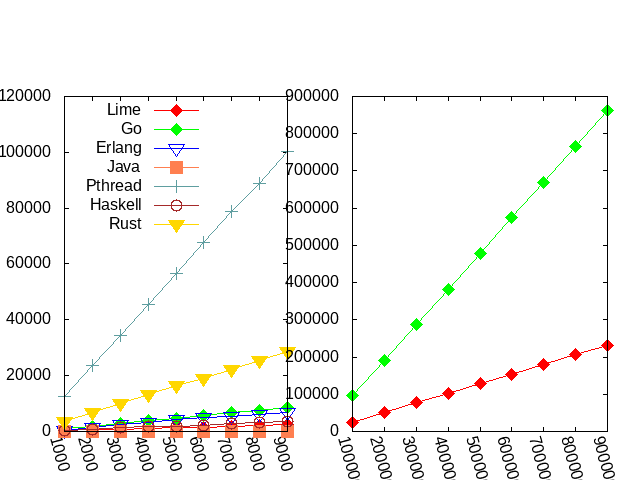

In [10]:
from IPython.display import Image
Image(filename='ex_MapReduce.png') 

In [11]:
heavyThreadTestCases = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
lightThreadTestCases = [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000]
import sys
import re
import glob
import resource
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
allLanguages = [ "Pthread", "Haskell", "Go", "Erlang", "Java", "Lime", "Rust"]
lightLanguages = [ "Go", "Lime"]
outputDir="measurements/"
datap = re.compile('num:\\s+([0-9]+).*') #group 1
realp = re.compile('real\\s+([0-9]+)m([0-9]+\\.[0-9]+)s.*') #group 1 and group 2
userp = re.compile('user\\s+([0-9]+)m([0-9]+\\.[0-9]+)s.*')
sysp = re.compile('sys\\s+([0-9]+)m([0-9]+\\.[0-9]+)s.*')


testcaseName = "mapreduce"
repeats = 60
def parse():
    for l in allLanguages:
        res = [] 
        vals = []
        
        for i in range(repeats):
            fileName = "measurements/" + l + "." + testcaseName + ".heavythread." + str(i) + ".txt"        
            ifp = open(fileName)
            line = ifp.readlines()
            result = []
            row = [None, None]
            for x in line:
                if row[0] is None:
                    m = datap.match(x)
                    if m is not None:
                        row[0] = int(m.group(1))
                elif row[1] is None:
                    t = realp.match(x)
                    if t is not None:
                        row[1] = int(t.group(1))*60+float(t.group(2))*1000
                        result.append(row)
                        row = [None, None]
            ifp.close()
            res.append(result)
        #print(res)
        # error bar
        #print(l)
        aluminum_stds = []
        aluminum_means = []
        for kk in range(len(heavyThreadTestCases)):
            err = []
            for k in res:
                err.append(k[kk][1])
            #print(heavyThreadTestCases[kk])
            aluminum = np.array(err)
            aluminum_means.append(np.mean(aluminum))
            #print(aluminum_mean)
            aluminum_stds.append(np.std(aluminum))
            #print(aluminum_std)
        # plot
        # Define labels, positions, bar heights and error bar heights
        labels = heavyThreadTestCases
        x_pos = heavyThreadTestCases
        CTEs = aluminum_means
        error = aluminum_stds
        
        fig, ax = plt.subplots()
        ax.bar(x_pos, CTEs, yerr=error, align='center',alpha=0.5, ecolor='black', capsize=10)
        #ax.errorbar(x_pos, CTEs, yerr=error, fmt='-o')
        ax.set_ylabel('Standard Deviation')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)
        ax.set_title('MapReduce: '+ l + ' HeavyThread')
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        #plt.savefig('ErrorBar/'+l + '.heavythread.' + 'with.error.bar.png')
        plt.savefig('ErrorBar/'+l + '.heavythread.' + 'only.standard.deviation.png')
        #plt.show()
    print("*"*100)
    for l in lightLanguages:
        res = [] 
        vals = []
        
        for i in range(repeats):
            fileName = "measurements/" + l + "." + testcaseName + ".lightthread." + str(i) + ".txt"        
            ifp = open(fileName)
            line = ifp.readlines()
            result = []
            row = [None, None]
            for x in line:
                if row[0] is None:
                    m = datap.match(x)
                    if m is not None:
                        row[0] = int(m.group(1))
                elif row[1] is None:
                    t = realp.match(x)
                    if t is not None:
                        row[1] = int(t.group(1))*60+float(t.group(2))*1000
                        result.append(row)
                        row = [None, None]
            ifp.close()
            res.append(result)
        print(l)
        
        aluminum_stds = []
        aluminum_means = []
        for kk in range(len(heavyThreadTestCases)):
            err = []
            for k in res:
                err.append(k[kk][1])
            #print(heavyThreadTestCases[kk])
            aluminum = np.array(err)
            aluminum_means.append(np.mean(aluminum))
            #print(aluminum_mean)
            aluminum_stds.append(np.std(aluminum))
            #print(aluminum_std)
        # plot
        # Define labels, positions, bar heights and error bar heights
        labels = lightThreadTestCases
        x_pos = lightThreadTestCases
        CTEs = aluminum_means
        error = aluminum_stds
        
        fig, ax = plt.subplots()
        ax.bar(x_pos, CTEs, yerr=error, align='center',alpha=0.5, ecolor='black', capsize=10)
        #ax.errorbar(x_pos, CTEs, yerr=error, fmt='-o')
        ax.set_ylabel('Standard Deviation')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)
        ax.set_title('MapReduce: '+ l + ' LightThread')
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        #plt.savefig('ErrorBar/'+l + '.lightthread.' + 'with.error.bars.png')
        plt.savefig('ErrorBar/'+l + '.lightthread.' + 'only.standard.deviation.png')
        #plt.show()
                                
parse()

NameError: name 'heavyThreadTestCases' is not defined